# Load extracted KG recipes and fit a GNN via PyTorch Geometric

This notebook provides an example of how to load in the extracted triples from https://www.allrecipes.com and fit them to a heterogenous GNN via pytorch geometric. 

In [1]:
import os, sys

import numpy as np 
import torch as tn
import torch.optim 
from torch.nn import ModuleDict 
import torch_geometric.transforms as T
from torch_geometric.nn import to_hetero, Linear, GATConv, HeteroConv
from torch_geometric.data import HeteroData
import matplotlib.pyplot as plt

sys.path = ['/Users/walder2/kg_uq/'] + sys.path
path_to_data = '/Users/walder2/kg_uq/recipe_data'

from recipe_data import recipe_kg_to_hetero

/Users/walder2/torch_geometric_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define the Hetero GNN

This is just one example. You can head to the docs here https://pytorch-geometric.readthedocs.io/en/latest/cheatsheet/gnn_cheatsheet.html and find heterogenous GNNs that handle features (and possibly lazy-initialization).

The GNN maps from `HeteroData()` to $\mathbb{R}^d$, with a linear layer at the bottom aggregating from each node type. If you change this, just be mindful of the loss function used later on. 

Note that the emebeddings for the features are `torch.float32`, so you need to be mindful of how you initialize the variables of the GNN.

In [2]:
log_sig = torch.nn.LogSigmoid()

class HeteroGNN(tn.nn.Module):
    def __init__(self, hidden_channels, emb_dim, num_layers, edge_types, node_types):
        super().__init__()
        
        self.emb_dim = emb_dim
        self.convs = tn.nn.ModuleList()
        
        for _ in range(num_layers):
            conv = HeteroConv({key : GATConv((-1, -1), hidden_channels, add_self_loops=False) for key in edge_types}, aggr='sum')
            self.convs.append(conv)
            
        self.lin_dict = ModuleDict({x: Linear(hidden_channels, emb_dim, bias=False) for x in node_types})
        
        
        
    def forward(self, x_dict, edge_index_dict):
        rv = tn.zeros(self.emb_dim)
        
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}
            
        # may want to change the aggregation layer here
        for key, x in x_dict.items():
            rv += self.lin_dict[key](torch.mean(x, dim=0))
        return rv
        

# Load the data 

The returned dictionary contains:

    - 'train': a list of `HeteroData()` objects (one for each subgraph)
    - 'kg': the KG as a `DataFrame`
    - 'embedding_maps': Tuple of node type sentence enumeration, and corresponding node type embeddings
    
You need to specify the path to `./recipe_data` in `data_dir`. You can speficy an embedding model for the sentences by passing a string to `sentence_transformer_model`, which corresponds to a type of embeddings for `SentenceTransformer` objects (see https://www.sbert.net/). `Passing `undirected = True`, supplies reverse edges for fitting. 
    

In [3]:
data_dict = recipe_kg_to_hetero(data_dir=path_to_data, sentence_transformer_model='all-MiniLM-L6-v2', undirected=True)

### Looking at a KG subgraph

We can take a look at the first subgraph extracted below. 

In [13]:
kg = data_dict['kg']
kg[kg['kg_idx'] == 1]

,head,head_type,relation,tail,tail_type,kg_idx,kg_name
18,bonbons,recipe,hasCharacteristic,145 Calories,nutrition,1,bonbons
19,bonbons,recipe,hasCharacteristic,8g Fat,nutrition,1,bonbons
20,bonbons,recipe,hasCharacteristic,19g Carbs,nutrition,1,bonbons
21,bonbons,recipe,hasCharacteristic,1g Protein,nutrition,1,bonbons
22,bonbons,recipe,hasIngredient,butter,ingredient,1,bonbons
23,bonbons,recipe,hasIngredient,2 pounds confectioners’ sugar,ingredient,1,bonbons
24,bonbons,recipe,hasIngredient,sweetened condensed milk,ingredient,1,bonbons
25,bonbons,recipe,hasIngredient,coconut flakes,ingredient,1,bonbons
26,bonbons,recipe,hasIngredient,walnuts,ingredient,1,bonbons
27,bonbons,recipe,hasIngredient,vanilla,ingredient,1,bonbons


Looking at the contents of, `tail` we may want to do some text clean up. We won't do that here, but should consider that at a different time.

# Initialize the GNN

`emb_dim` is the dimension mapped to by the encoder. You need to specify the edge types and node types to initialize the GNN as defined. 


Model is fit by performing an N-ary classification. Each graph is embedded to get $f_{\theta}(G_i) = \boldsymbol{d}_i$. The optimization maximizes 

$$ \sum_{i=1}^{N} P(G_i \vert D ) = \sum_{i=1}^{n} \frac{\sigma(\boldsymbol{d}_i^{T}\boldsymbol{d}_i)}{\sum_{i=1}^{N}  \sigma(\boldsymbol{d}_i^{T}\boldsymbol{d}_j) }, $$

where $\sigma(x) = \frac{1}{1 + \exp(-x)}$ is a sigmoid function This is not a great way to do this, but for a first pass try it out. 

In [5]:
emb_dim = 10 
train = data_dict['train']

edge_types = tuple(set((y for x in train for y in x.edge_types)))
node_types = tuple((y for x in train for y in x.node_types))

encoder = HeteroGNN(hidden_channels=16, num_layers=2, emb_dim=emb_dim, edge_types=edge_types, node_types=node_types)

In [6]:
epochs = 100
ntrain = len(train)
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.90)

for epoch in range(epochs):
    optimizer.zero_grad()
    
    rv = tn.zeros((ntrain, emb_dim))
    
    for i in range(ntrain):
        rv[i] = encoder(train[i].x_dict, train[i].edge_index_dict)
        
    d_ij = log_sig(tn.matmul(rv, rv.T))
    loss = -tn.sum(tn.diag(d_ij) - tn.logsumexp(d_ij, dim=1))
    
    loss.backward()
    optimizer.step()
    scheduler.step()

    if (epoch+1) % 10 == 0:
        print('Epoch %s, loss %s' % (repr(epoch+1), repr(loss.detach())))
        

Epoch 10, loss tensor(43.0748)
Epoch 20, loss tensor(40.1044)
Epoch 30, loss tensor(39.3637)
Epoch 40, loss tensor(38.6750)
Epoch 50, loss tensor(37.7145)
Epoch 60, loss tensor(37.7045)
Epoch 70, loss tensor(37.7004)
Epoch 80, loss tensor(37.7003)
Epoch 90, loss tensor(37.7002)
Epoch 100, loss tensor(37.7002)


## Search-depth on training set should be perfect


In [7]:
## embedd the KG subgraphs
rv = torch.zeros((ntrain, emb_dim))

for i in range(ntrain):
    rv[i] = encoder(train[i].x_dict, train[i].edge_index_dict)

d_ij = log_sig(torch.matmul(rv, rv.T))
d_ij = d_ij - torch.logsumexp(d_ij, dim=1, keepdim=True)

# finding nearest-neighbors in embedding space
sd = torch.arange(ntrain**2) % ntrain
sd = sd.reshape(-1, ntrain)
temp = torch.zeros((ntrain, ntrain), dtype=int) - 1
temp[torch.eye(ntrain, dtype=bool)] = torch.arange(ntrain)

sd = sd[torch.argsort(-d_ij, dim=1) == torch.arange(ntrain).reshape(-1, 1)]
sd = sd.detach().tolist()


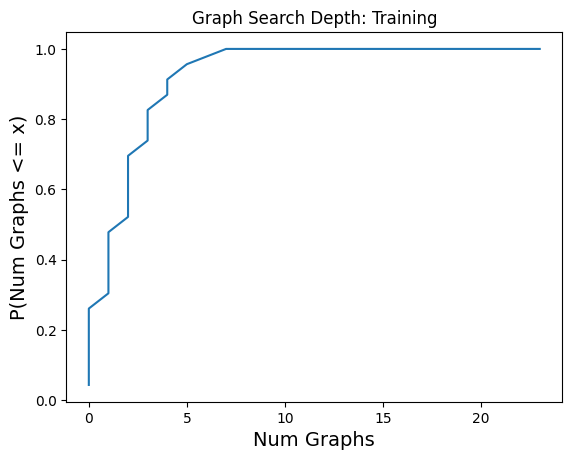

In [8]:
### set plot so we can plot as we go

fig, ax = plt.subplots()
ax.set_ylabel("P(Num Graphs <= x)", fontsize=14)
ax.set_xlabel('Num Graphs', fontsize=14)
ax.title.set_text('Graph Search Depth: Training') 

y_axis = np.ones(ntrain+1)
y_axis[:-1] = np.arange(1.0,ntrain+1)/ntrain

ax.plot(np.sort(sd+[ntrain]), y_axis)

plt.show()

## Lets take a look at which kgs were similar.

Things like cookies should be close to cookies, but maybe ingredients and directions have an influence on the embeddings. 


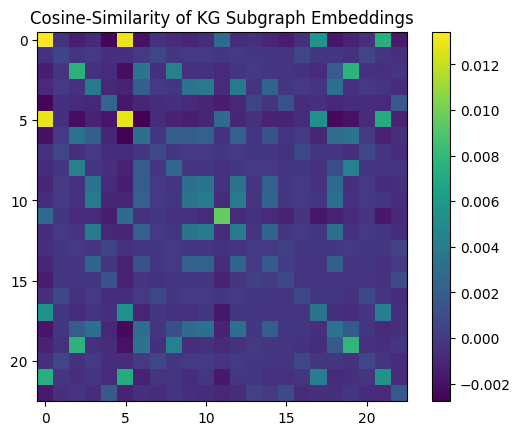

In [14]:
## cosine similarity plot then pick out the kgs that are similar
cmat = torch.sum(rv.reshape(ntrain, 1, emb_dim) * rv, dim=2)
cnorms = torch.sum(rv**2, dim=1)
cmat = cmat / cnorms.reshape(1, ntrain)
cmat = cmat / cnorms.reshape(ntrain, 1)

#cmat = torch.exp(d_ij)

fig, ax = plt.subplots()
cmat = cmat.detach().numpy()
c = ax.imshow(cmat)
ax.set_title('Cosine-Similarity of KG Subgraph Embeddings')
fig.colorbar(c)
None


In [16]:
k = 5
for i, x in enumerate(kg['kg_name'].unique()):
    top = [np.unique(kg[kg['kg_idx'] == i]['kg_name'])[0] for i in np.argsort(-cmat[i, :])[:k]]
    top = '\n\t- '.join(['']+top)
    print(f'Top {k} neighbors of {x} are: {top}.\n')

Top 5 neighbors of baked apples are: 
	- baked apples
	- chocolate cookies
	- twix pie
	- oreo balls
	- fudge.

Top 5 neighbors of bonbons are: 
	- chocolate strawberry cheesecake
	- perfect pumpkin pie
	- nutella cookies
	- bonbons
	- french apple cake.

Top 5 neighbors of brownie pie are: 
	- pecan shortbread cookies
	- brownie pie
	- cocnut pie
	- chocolate stout cake
	- peanut butter pie.

Top 5 neighbors of caramel cake are: 
	- gooey butter cookies
	- french apple cake
	- caramel cake
	- english toffee
	- peanut butter pie.

Top 5 neighbors of carmel apple chocolate bark are: 
	- carmel apple chocolate bark
	- vanilla frozen yogurt
	- lemon shortbread cookies
	- healthier apple crisp
	- healthy chocolate pudding.

Top 5 neighbors of chocolate cookies are: 
	- baked apples
	- chocolate cookies
	- twix pie
	- oreo balls
	- fudge.

Top 5 neighbors of chocolate stout cake are: 
	- brownie pie
	- pecan shortbread cookies
	- chocolate stout cake
	- peanut butter pie
	- gooey butter coo

# Todo

Extract more KGs, maybe consider a different schema. We'd like to add some noise via removing/add edges. It would also be nice to make sure that similar recipes with different extraction types are embedded close together. We should provide some search depth curves on this and start thinking about a better fit and UQ. 

Todo (sort of in order):

    - Clean up text in `tail` prior to sentence embeddings
    - Extract more recipes!
    - Add random edges and analze search depth
    - Start thinking about UQ (i.e. recommend edges? Freddy thoughts...) 